### [Voting Classifiers](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier)
- Combines conceptually different classifiers, then uses a __majority vote__ or __average predicted probabilities__ (soft vote) to predict class labels. They can be useful for a set of equally well performing models in order to balance out their individual weaknesses.

In [1]:
# example majority rule: voting='hard'

from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import VotingClassifier as VC

iris = datasets.load_iris(); X, y = iris.data[:, 1:3], iris.target

clf1 = LR(random_state=1)
clf2 = RFC(n_estimators=50, random_state=1)
clf3 = GNB()

eclf = VC(estimators=[('lr', clf1), 
                      ('rf', clf2), 
                      ('gnb', clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.95 (+/- 0.04) [Logistic Regression]
Accuracy: 0.94 (+/- 0.04) [Random Forest]
Accuracy: 0.91 (+/- 0.04) [naive Bayes]
Accuracy: 0.95 (+/- 0.04) [Ensemble]


### Soft Voting Classifier
- Returns class label as argmax(sum of predictions)
- `weights` assigns weights to each classifier - class probabilities are multiplied by their respective weights. Final class label is derived from the weighted average.
- Below: how the decision regions change when a soft VotingClassifier is based on a linear __Support Vector Machine__, a __Decision Tree__, and a __K-nearest neighbor classifier__:

In [2]:
# example weighted averages (soft vote)
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier as VC

# Loading some example data
iris = datasets.load_iris(); X = iris.data[:,[0,2]]; y = iris.target

# Training classifiers
clf1 = DTC(max_depth=4)
clf2 = KNC(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VC( estimators=[('dt', clf1), 
                       ('knn', clf2), 
                       ('svc', clf3)],
                       voting='soft', weights=[2, 1, 2])

clf1 = clf1.fit(X, y)
clf2 = clf2.fit(X, y)
clf3 = clf3.fit(X, y)
eclf = eclf.fit(X, y)

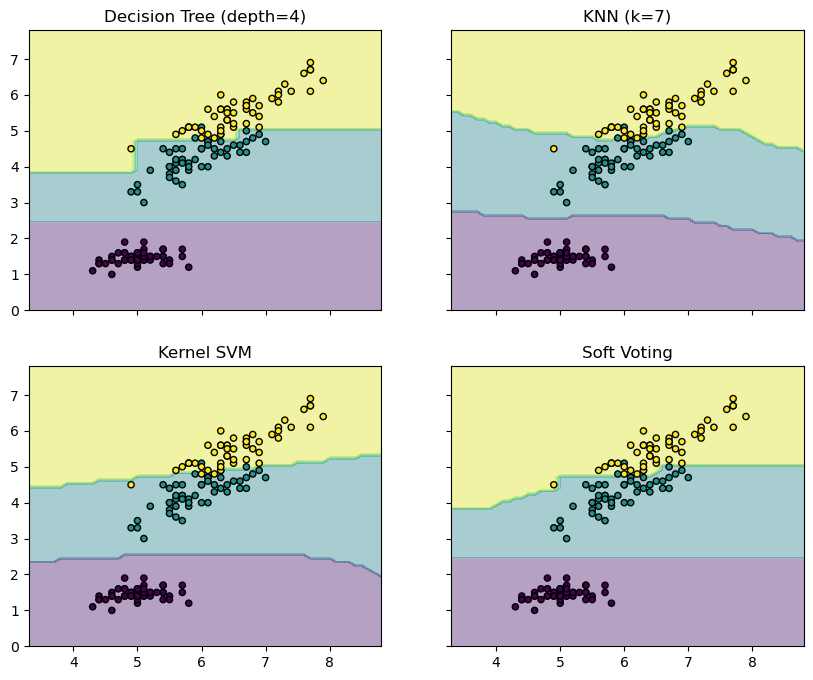

In [5]:
# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

import numpy as np
import matplotlib.pyplot as plt

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

In [9]:
# using cross-validation
from sklearn.model_selection import GridSearchCV
clf1 = LR(random_state=1)
clf2 = RFC(random_state=1)
clf3 = GNB()
eclf = VC(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')

params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200]}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
#grid = grid.fit(iris.data, iris.target) -- TODO: fix convergence error

### [Voting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html#sklearn.ensemble.VotingRegressor)
- combine conceptually different machine learning regressors and return the average predicted values. Such a regressor can be useful for a set of equally well performing models in order to balance out their individual weaknesses.

In [10]:
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import VotingRegressor as VR

In [11]:
X, y = load_diabetes(return_X_y=True)

reg1 = GBR(random_state=1)
reg2 = RFR(random_state=1)
reg3 = LR()

reg1.fit(X,y); reg2.fit(X,y); reg3.fit(X,y)

ereg = VR([('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg.fit(X,y)

VotingRegressor(estimators=[('gb', GradientBoostingRegressor(random_state=1)),
                            ('rf', RandomForestRegressor(random_state=1)),
                            ('lr', LinearRegression())])

In [12]:
# make 20 first predictions
xt = X[:20]

pred1 = reg1.predict(xt)
pred2 = reg2.predict(xt)
pred3 = reg3.predict(xt)
pred4 = ereg.predict(xt)

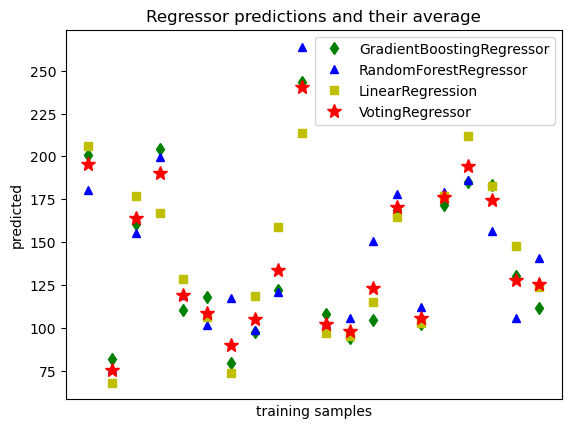

In [13]:
# red stars = average prediction according to Voting Regressor
plt.figure()
plt.plot(pred1, 'gd', label='GradientBoostingRegressor')
plt.plot(pred2, 'b^', label='RandomForestRegressor')
plt.plot(pred3, 'ys', label='LinearRegression')
plt.plot(pred4, 'r*', ms=10, label='VotingRegressor')

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')
plt.show()